In [24]:
# Cell 1: Import Packages
import scanpy as sc
import scvi
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# (Optional) Set a nice plotting style
sc.set_figure_params(scanpy=True)


In [25]:
# Cell 2: Load Your Data into AnnData (if not already loaded)
# Adjust these paths to your files.
import scipy.io

# Read the count matrix (Matrix Market format)
mat = scipy.io.mmread("genes/matrix.mtx")

# Read barcodes (one barcode per line)
barcodes = pd.read_csv("genes/barcodes.tsv", header=None, sep="\t")

# Read genes (if genes.tsv has two columns, choose the desired one)
genes = pd.read_csv("genes/genes.tsv", header=None, sep="\t")

# Create AnnData object.
# Here, we assume mat is in cells x genes format; if not, use mat = mat.T
adata = anndata.AnnData(
    X=mat,
    obs=pd.DataFrame(index=barcodes[0]),
    var=pd.DataFrame(index=genes[0])
)
adata.obs.index.name = "barcode"
adata.var.index.name = "gene"

# (Optional) Convert matrix to CSR format
if hasattr(adata.X, "tocsr"):
    adata.X = adata.X.tocsr()

# Print basic info
print(adata)


/home/nazira.dunbayeva/.conda/envs/scvi_env/lib/python3.10/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a supported type.Continue using for this minor version at your own risk.
  warnings.warn(msg, FutureWarning)


AnnData object with n_obs × n_vars = 1259793 × 35637


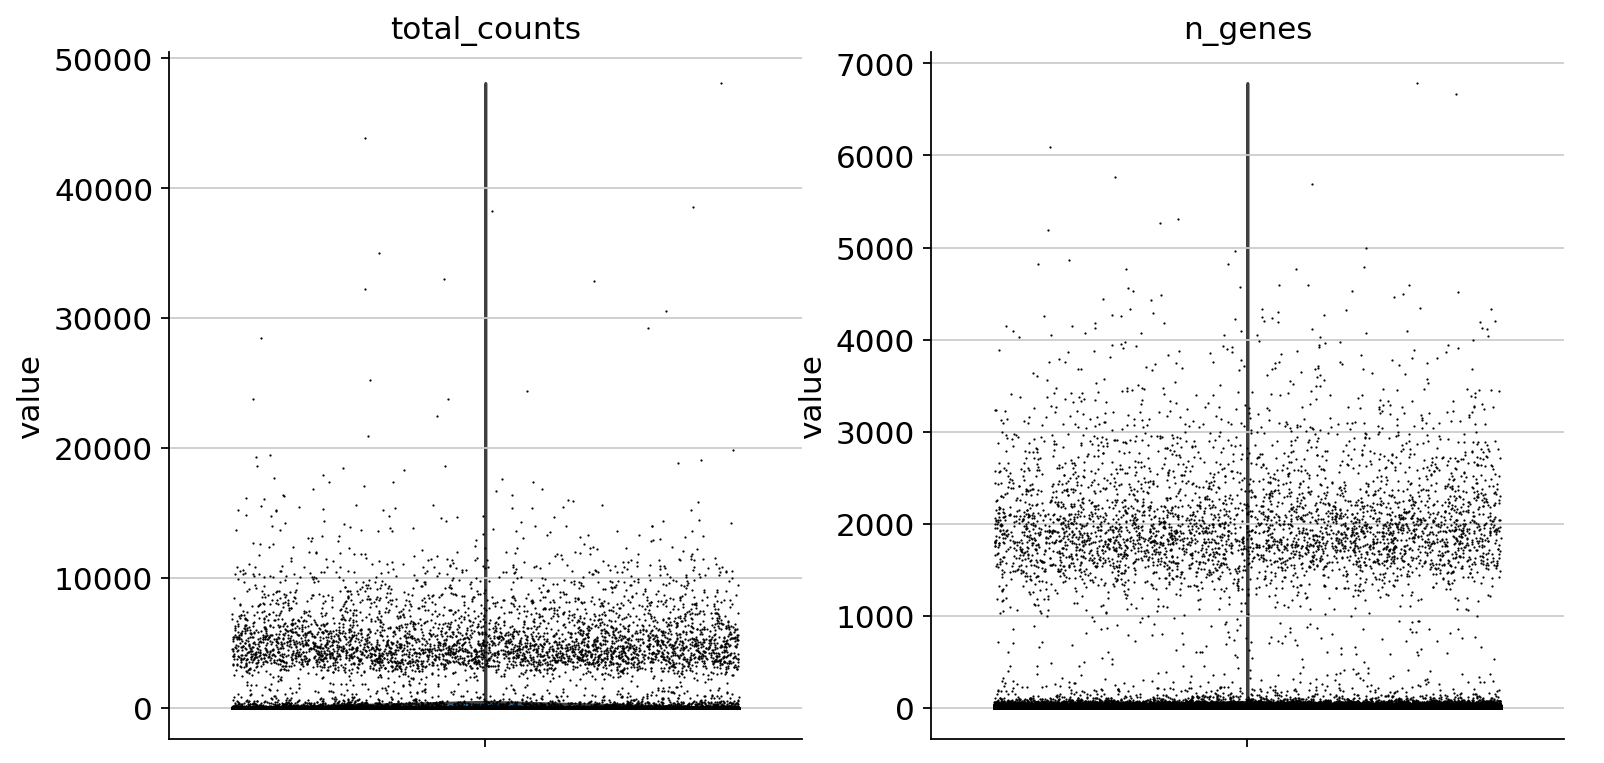

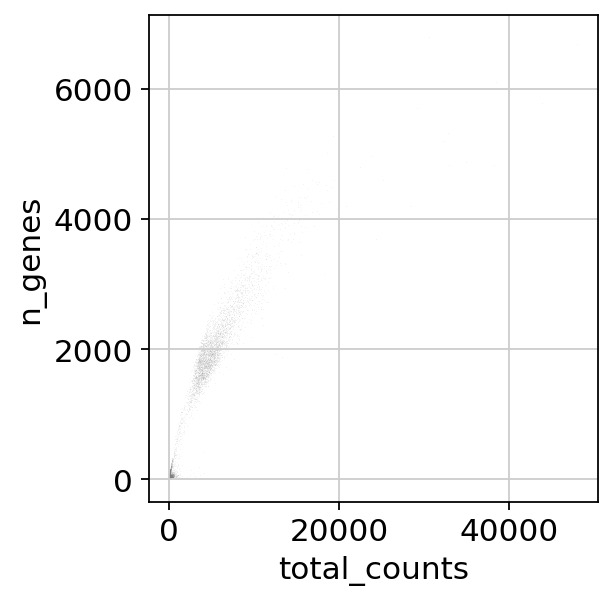

After filtering, AnnData shape: (4051, 35637)


In [26]:
# Cell 3: Preprocessing & Quality Control
# Compute QC metrics
adata.obs['total_counts'] = np.array(adata.X.sum(axis=1)).flatten()
adata.obs['n_genes'] = np.array((adata.X > 0).sum(axis=1)).flatten()

# Visualize QC metrics
sc.pl.violin(adata, ['total_counts', 'n_genes'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='n_genes')

# Filter cells (e.g., keep cells with > 1000 total counts)
sc.pp.filter_cells(adata, min_counts=1000)
print("After filtering, AnnData shape:", adata.shape)


In [29]:
# Cell 4: Set up scvi‑tools with your AnnData object
# Here, we do not use any batch info, so batch_key=None. 
scvi.model.SCVI.setup_anndata(adata, batch_key=None)

# Initialize the SCVI model.
# n_hidden (size of hidden layer) and n_latent (latent dimension) can be tuned.
model = scvi.model.SCVI(adata, n_hidden=128, n_latent=10)

# Train the model.
# Adjust max_epochs as needed (here, 100 is used for a quick start).
model.train(max_epochs=100)


/home/nazira.dunbayeva/.conda/envs/scvi_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nazira.dunbayeva/.conda/envs/scvi_env/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/nazira.dunbayeva/.conda/envs/scvi_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nazira.dunbayeva/.conda/envs/scvi_env/lib/pyth ...
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('mediu

Epoch 100/100: 100%|██████████| 100/100 [00:46<00:00,  2.12it/s, v_num=1, train_loss_step=6.16e+3, train_loss_epoch=6e+3] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s, v_num=1, train_loss_step=6.16e+3, train_loss_epoch=6e+3]


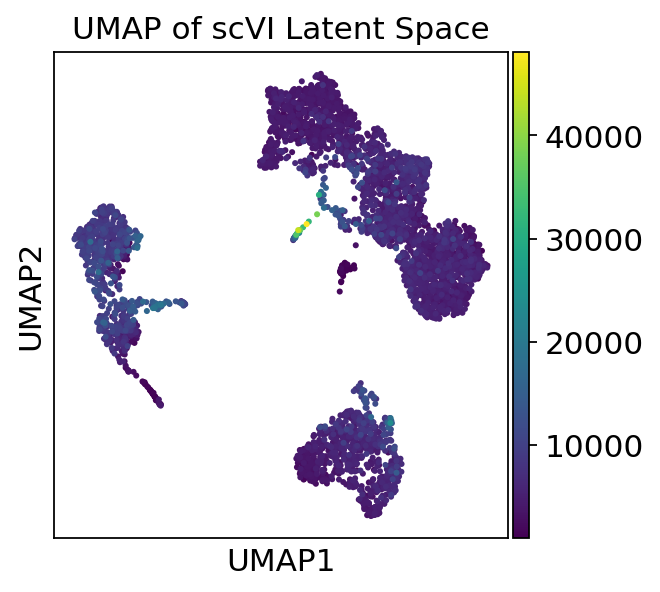

In [30]:
# Cell 5: Extract the Latent Representation and Visualize with UMAP
# The learned latent space is stored in X_scVI.
adata.obsm["X_scVI"] = model.get_latent_representation()

# Compute the neighbor graph using the latent space
sc.pp.neighbors(adata, use_rep="X_scVI")

# Run UMAP on the latent space
sc.tl.umap(adata)

# Plot UMAP (color by total counts as an example; you could also color by other metadata)
sc.pl.umap(adata, color=["total_counts"], title="UMAP of scVI Latent Space", show=True)


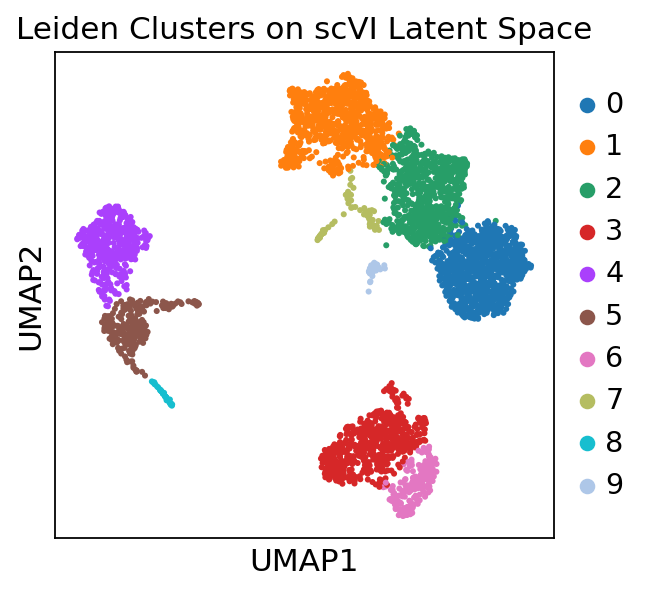

In [31]:
# Cell 6: Clustering on the Latent Space using Leiden Clustering
# Run Leiden clustering on the neighbor graph computed from the scVI latent space.
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=["leiden"], title="Leiden Clusters on scVI Latent Space", show=True)


In [32]:
# Cell 7: Differential Expression Analysis between Two Clusters
# For example, compare clusters "0" and "1"
de_results = model.differential_expression(
    groupby="leiden",
    group1="0",
    group2="1",
    mode="change"  # 'change' returns log fold-change and bayes factors
)

# Show top 10 marker genes sorted by Bayes factor
top_markers = de_results.sort_values("bayes_factor", ascending=False).head(10)
print("Top Differentially Expressed Genes (cluster 0 vs 1):")
print(top_markers)


DE...: 100%|██████████| 1/1 [00:08<00:00,  8.56s/it]
Top Differentially Expressed Genes (cluster 0 vs 1):
                 proba_de  proba_not_de  bayes_factor        scale1  \
gene                                                                  
ENSG00000202187       1.0           0.0     18.420681  1.553969e-06   
ENSG00000100453       1.0           0.0     18.420681  4.212885e-05   
ENSG00000142347       1.0           0.0     18.420681  2.149206e-05   
ENSG00000235008       1.0           0.0     18.420681  3.746489e-06   
ENSG00000186049       1.0           0.0     18.420681  1.713069e-05   
ENSG00000273897       1.0           0.0     18.420681  1.315373e-06   
ENSG00000174776       1.0           0.0     18.420681  8.266375e-08   
ENSG00000124507       1.0           0.0     18.420681  8.070413e-07   
ENSG00000167414       1.0           0.0     18.420681  1.480931e-05   
ENSG00000211739       1.0           0.0     18.420681  3.749352e-06   

                       scale2  pseudocoun

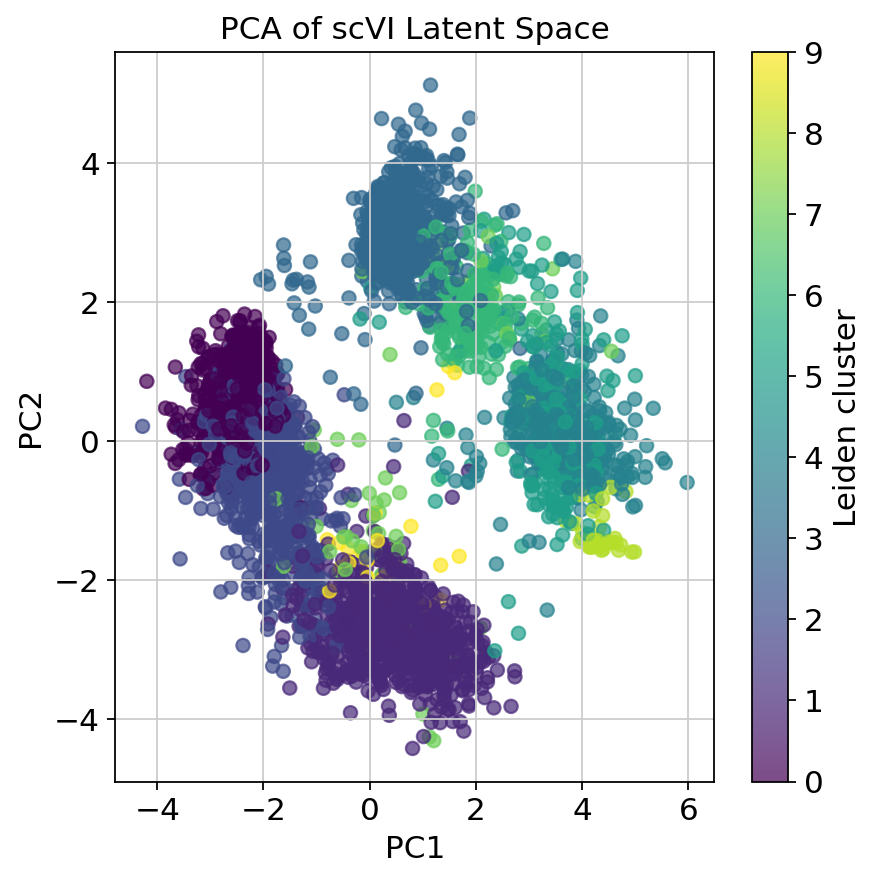

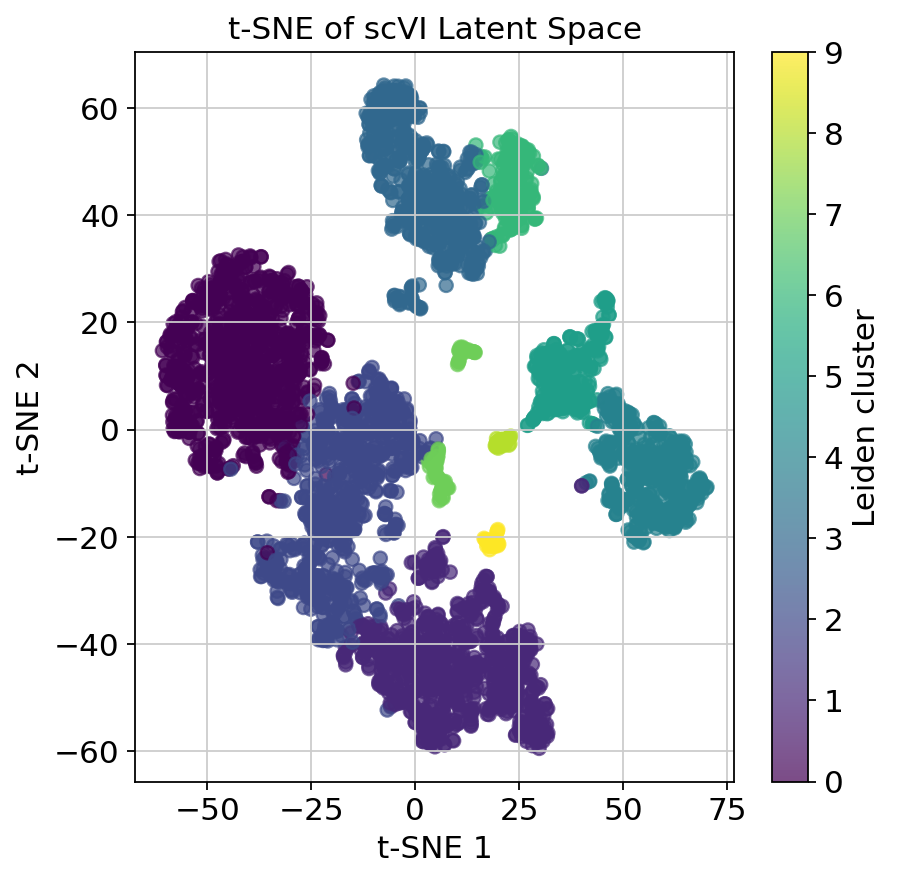

In [33]:
# Cell 8: Additional Visualization - PCA and t-SNE of the scVI Latent Space
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA on the scVI latent space (n_components set to the latent dimension, here 10)
pca_model = PCA(n_components=10)
adata.obsm["X_pca_scVI"] = pca_model.fit_transform(adata.obsm["X_scVI"])

# Plot PCA (PC1 vs PC2)
plt.figure(figsize=(6,6))
plt.scatter(adata.obsm["X_pca_scVI"][:, 0], adata.obsm["X_pca_scVI"][:, 1],
            c=pd.Categorical(adata.obs["leiden"]).codes, cmap="viridis", alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of scVI Latent Space")
plt.colorbar(label="Leiden cluster")
plt.show()

# t-SNE on the scVI latent space
tsne_model = TSNE(n_components=2, random_state=42)
adata.obsm["X_tsne_scVI"] = tsne_model.fit_transform(adata.obsm["X_scVI"])

# Plot t-SNE (tSNE1 vs tSNE2)
plt.figure(figsize=(6,6))
plt.scatter(adata.obsm["X_tsne_scVI"][:, 0], adata.obsm["X_tsne_scVI"][:, 1],
            c=pd.Categorical(adata.obs["leiden"]).codes, cmap="viridis", alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE of scVI Latent Space")
plt.colorbar(label="Leiden cluster")
plt.show()
